In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
from time import time

In [2]:
import tensorflow as tf

In [3]:
from ModelLibrary import *

<h2>Variational Autoencoder</h2>

<p>An autoencoding model that takes an input, in this case it will be the load condtions and a part image, and produces a latentspace, in terms of mean and standard deviation. We then use a decoder to expand this latent space on a specific normal distribution to regenerat the optimal part.</p>
<p>The input space for this model would be an image of a current part(as a seed) the load conditions could be kept as either a vector or could be expanded into an image like the iterative model. The latent space would have to be standardized as would the image resolutions. The output would just be the final iteration of the part.</p>
</div>
<p>The second stage to this setup would have us take the decoder and train a new encoder to produce the same latent space but with only the format vector and a noise value. This would then have to be pluged into the decoder to produce the optimal part.</p>
<p>A special training regime would have to be run for this setup. The load encoder would produce a set of means and standard deviations. The mean of this set(no deviation) should decode into the optimal part for the load conditions. The standard deviations can be added to get some similar parts around the optimal.</p>



In [ ]:
#overview of the data
#dataDirectory = os.path.join(os.getcwd(),'data')
dataDirectory = r"E:\TopoptGAfileSaves\ComplianceMinimization\Agents"
DATA_FILE_PATH = os.path.join(dataDirectory,'100_50')

dir_list = os.listdir(DATA_FILE_PATH)
max_data_points = len(dir_list)
print("Number of data points: {}".format(len(dir_list)))
print(dir_list[0])



In [4]:
class VariationalAutoEncoder(tf.keras.Model):
    def __init__(self,imageShape,latenDims):
        super(VariationalAutoEncoder,self).__init__()
        self.encoder = buildEncoder(imageShape,latenDims,10)
        self.decoder = buildDecoder(latenDims,imageShape,10)
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean( name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #print(z.shape)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result() }

In [5]:
def createDataSample(res):
    im_array = np.random.normal(0,.1,size=(res,res))
    im_array = np.abs(im_array)

    for i in range(res):
        im_array[i,i] = 1 - np.abs(np.random.normal(0,.1))
    
    return im_array

def createData(number,res):
    data = np.zeros((number,res,res))
    for i in range(number):
        if(np.random.random() >= 0.5):
            data[i,:,:] = createDataSample(res)
        else:
            data[i,:,:] = np.fliplr(createDataSample(res))
    
    return data

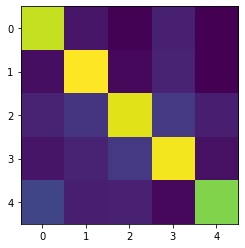

In [7]:
plt.imshow(createDataSample(5))

In [8]:
res = 5
num = 10
data = createData(num,res)
data = np.reshape(data,(num,res,res,1))

print(data.shape)

(10, 5, 5, 1)


In [9]:

vae = VariationalAutoEncoder((res,res),res)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(data, epochs=1)

ValueError: in user code:

    File "c:\Users\Nate\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Nate\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Nate\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Nate\AppData\Local\Temp/ipykernel_13836/2619329750.py", line 21, in train_step
        reconstruction = self.decoder(z)
    File "c:\Users\Nate\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Nate\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\layers\reshaping\reshape.py", line 118, in _fix_unknown_dimension
        raise ValueError(msg)

    ValueError: Exception encountered when calling layer "reshape" "                 f"(type Reshape).
    
    total size of new array must be unchanged, input_shape = [5, 25], output_shape = [5, 5]
    
    Call arguments received by layer "reshape" "                 f"(type Reshape):
      • inputs=tf.Tensor(shape=(None, 5, 25), dtype=float32)
